In [1]:
import cv2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
cv2.data.haarcascades

'C:\\Users\\sapta\\anaconda3\\envs\\python38\\lib\\site-packages\\cv2\\data\\'

In [4]:
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
smile_detector = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_smile.xml')

def detect_face(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_image = image.copy()
    face_rectangle = face_detector.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)
    for (x, y, width, height) in face_rectangle:
        cv2.rectangle(face_image, (x, y), (x + width, y + height), (0, 255, 0), 3)
    return face_image

def detect_smile(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_image = image.copy()
    face_rectangle = smile_detector.detectMultiScale(gray_image, scaleFactor=1.7, minNeighbors=22)
    for (x, y, width, height) in face_rectangle:
        cv2.rectangle(face_image, (x, y), (x + width, y + height), (255, 0, 0), 3)
    return face_image



In [5]:
live_cam = cv2.VideoCapture(0)

while True:
    ret, current_frame = live_cam.read(0)
    current_frame = detect_smile(detect_face(current_frame))
    
    cv2.imshow("Face detected", current_frame)
    key=cv2.waitKey(50)
    if key == ord("q"):
        break

live_cam.release()
cv2.destroyAllWindows()

In [2]:
pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Note: you may need to restart the kernel to use updated packages.


# for mediapipe use python 3.8

In [6]:
import cv2
import mediapipe as mp

In [7]:
# Initialize Mediapipe face mesh detector
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=5, min_detection_confidence=0.5)

# Initialize drawing utilities for landmarks
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [8]:
def detect_face_landmarks(image):
    """
    Detects facial landmarks using Mediapipe and draws them on the image.
    """
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = face_mesh.process(rgb_image)

    if result.multi_face_landmarks:
        for face_landmarks in result.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=image,  # Draw on the original image
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,  # Mesh drawing
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
            )
    return image

def detect_face_contours(image):
    """
    Detects and draws facial contours like eyes, mouth, etc.
    """
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = face_mesh.process(rgb_image)

    if result.multi_face_landmarks:
        for face_landmarks in result.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,  # Contours like eyes, lips
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style()
            )
    return image

In [9]:
# Initialize Mediapipe hand detector
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# Initialize drawing utilities for hand landmarks
mp_drawing = mp.solutions.drawing_utils

def detect_hand_landmarks(image):
    """
    Detects hand landmarks using Mediapipe and draws them on the image.
    """
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb_image)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image=image,  # Draw on the original image
                landmark_list=hand_landmarks,
                connections=mp_hands.HAND_CONNECTIONS,  # Draw connections between hand joints
                landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2),
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)
            )
    return image


In [10]:
# Start webcam feed
live_cam = cv2.VideoCapture(0)

while True:
    ret, current_frame = live_cam.read(0)

    # Apply hand and face landmark detection
    current_frame = detect_hand_landmarks(current_frame)  # Detect hand landmarks
    current_frame = detect_face_landmarks(current_frame)  # Detect face landmarks
    current_frame = detect_face_contours(current_frame)  # Detect face contours
    
    # Display the processed frame
    cv2.imshow("Hand and Face Detection", current_frame)
    
    # Break the loop if 'q' is pressed
    key = cv2.waitKey(50)
    if key == ord("q"):
        break

live_cam.release()
cv2.destroyAllWindows()


# virtual paint app

In [11]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize Mediapipe hand detector
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.8, min_tracking_confidence=0.8)

# Initialize drawing utilities for hand landmarks
mp_drawing = mp.solutions.drawing_utils

# Define canvas parameters
canvas = None
drawing = False  # Whether to draw or not
brush_color = (0, 255, 0)  # Default brush color (green)
brush_thickness = 5  # Brush thickness

# Function to detect hand landmarks and draw on canvas based on gestures
def detect_hand_gestures(image):
    global drawing, brush_color, brush_thickness, canvas

    # Convert the image to RGB as Mediapipe works with RGB images
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Process the image and get hand landmarks
    result = hands.process(rgb_image)
    
    # If canvas is not initialized, initialize it with the same size as the frame
    if canvas is None:
        canvas = np.zeros_like(image)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            # Get coordinates of index finger tip
            index_finger_tip = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP]
            h, w, _ = image.shape
            x, y = int(index_finger_tip.x * w), int(index_finger_tip.y * h)
            
            # Drawing condition: If the index finger is up and all other fingers are down, start drawing
            if is_drawing_gesture(hand_landmarks):
                drawing = True
                # Draw on the canvas
                cv2.circle(canvas, (x, y), brush_thickness, brush_color, -1)
            else:
                drawing = False

            # Change color based on gestures (e.g., using thumb and index finger pinch)
            if is_color_change_gesture(hand_landmarks):
                brush_color = (255, 0, 0)  # Change to blue
            if is_erasing_gesture(hand_landmarks):
                brush_color = (0, 0, 0)  # Change to black for erasing

            # Draw landmarks on the image
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Merge the canvas with the frame
    image = cv2.addWeighted(image, 0.5, canvas, 0.5, 0)
    return image

# Helper function to detect drawing gesture (index finger up, others down)
def is_drawing_gesture(hand_landmarks):
    # Check if the tip of the index finger is higher than its middle joint, and other fingers are down
    index_tip_y = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y
    index_mcp_y = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP].y
    return index_tip_y < index_mcp_y  # Drawing if index finger is up

# Helper function to detect color change gesture (thumb and index finger pinch)
def is_color_change_gesture(hand_landmarks):
    thumb_tip = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP]
    index_tip = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP]
    distance = np.sqrt((thumb_tip.x - index_tip.x)**2 + (thumb_tip.y - index_tip.y)**2)
    return distance < 0.05  # Color change when thumb and index are close

# Helper function to detect erasing gesture (open palm or specific gesture)
def is_erasing_gesture(hand_landmarks):
    # Check if all fingers are up (open palm gesture)
    index_tip_y = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y
    middle_tip_y = hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].y
    ring_tip_y = hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].y
    pinky_tip_y = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].y
    return (index_tip_y < middle_tip_y) and (middle_tip_y < ring_tip_y) and (ring_tip_y < pinky_tip_y)

# Start webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Flip the image horizontally for a selfie view
    frame = cv2.flip(frame, 1)
    
    # Detect hand gestures and apply virtual paint
    frame = detect_hand_gestures(frame)
    
    # Show the frame
    cv2.imshow("Virtual Paint App", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and destroy all OpenCV windows
cap.release()
cv2.destroyAllWindows()


# House Pricing Prediction

In [3]:
pip install scikit-learn numpy pandas matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

In [2]:
housing_dataset=pd.read_csv("./BostonHousing.csv")

In [3]:
housing_dataset.shape

(506, 14)

In [4]:
housing_dataset.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


<Axes: >

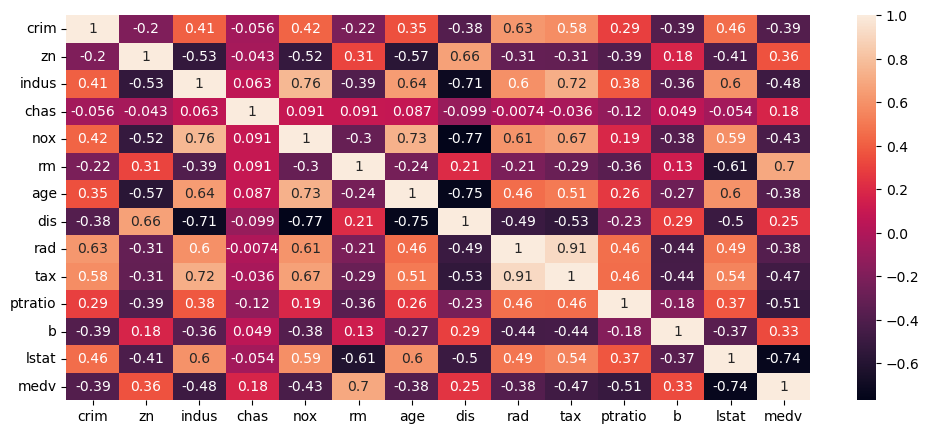

In [13]:
plt.figure(figsize=(12, 5))
sns.heatmap(housing_dataset.corr(), annot=True)

In [15]:
X = housing_dataset.drop(["medv"], axis=1)
y = housing_dataset.filter(["medv"], axis=1)

In [16]:
X.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [17]:
y.head()

,medv
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [19]:
house_predictor = LinearRegression()
house_predictor.fit(X_train, y_train)

LinearRegression()

In [24]:
y_pred

array([[28.99672362],
       [36.02556534],
       [14.81694405],
       [25.03197915],
       [18.76987992],
       [23.25442929],
       [17.66253818],
       [14.34119   ],
       [23.01320703],
       [20.63245597],
       [24.90850512],
       [18.63883645],
       [-6.08842184],
       [21.75834668],
       [19.23922576],
       [26.19319733],
       [20.64773313],
       [ 5.79472718],
       [40.50033966],
       [17.61289074],
       [27.24909479],
       [30.06625441],
       [11.34179277],
       [24.16077616],
       [17.86058499],
       [15.83609765],
       [22.78148106],
       [14.57704449],
       [22.43626052],
       [19.19631835],
       [22.43383455],
       [25.21979081],
       [25.93909562],
       [17.70162434],
       [16.76911711],
       [16.95125411],
       [31.23340153],
       [20.13246729],
       [23.76579011],
       [24.6322925 ],
       [13.94204955],
       [32.25576301],
       [42.67251161],
       [17.32745046],
       [27.27618614],
       [16

In [21]:
y_pred=house_predictor.predict(X_test)

In [26]:
print ("Mean Absolute Error: ",metrics.mean_absolute_error(y_test, y_pred))
print ('Mean Squared Error: ' , metrics.mean_squared_error(y_test, y_pred))
print ('Root Mean Squared Error: ' , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error:  3.189091965887852
Mean Squared Error:  24.291119474973613
Root Mean Squared Error:  4.928602182665346


In [25]:
compare_df = pd.DataFrame({'Actual': y_test.values.tolist(),'Predicted': y_pred.tolist()})

compare_df

,Actual,Predicted
0,[23.6],[28.996723619824962]
1,[32.4],[36.0255653356722]
2,[13.6],[14.816944045388281]
3,[22.8],[25.031979150399465]
4,[16.1],[18.76987991524815]
...,...,...
97,[17.9],[-0.16423699568661831]
98,[9.6],[13.68486681528585]
99,[17.2],[16.18359697171342]
100,[22.5],[22.27621999353341]


In [34]:
house_predictor.coef_

array([[-1.13055924e-01,  3.01104641e-02,  4.03807204e-02,
         2.78443820e+00, -1.72026334e+01,  4.43883520e+00,
        -6.29636221e-03, -1.44786537e+00,  2.62429736e-01,
        -1.06467863e-02, -9.15456240e-01,  1.23513347e-02,
        -5.08571424e-01]])

In [49]:
singlePoint=X_test.values[2].reshape(1,-1)
singlePoint

array([[1.0574e-01, 0.0000e+00, 2.7740e+01, 0.0000e+00, 6.0900e-01,
        5.9830e+00, 9.8800e+01, 1.8681e+00, 4.0000e+00, 7.1100e+02,
        2.0100e+01, 3.9011e+02, 1.8070e+01]])

In [50]:
house_predictor.predict(singlePoint)

C:\Users\sapta\anaconda3\envs\python38\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[14.81694405]])

In [48]:
y_test

,medv
173,23.6
274,32.4
491,13.6
72,22.8
452,16.1
...,...
412,17.9
436,9.6
411,17.2
86,22.5


In [3]:
# pip install SpeechRecognition pyttsx3
import speech_recognition as sr
import pyttsx3

# Initialize recognizer and TTS engine
recognizer = sr.Recognizer()
engine = pyttsx3.init()

def speak(text):
    engine.stop()  # Stop any ongoing speech
    engine.say(text)
    engine.runAndWait()

def listen():
    with sr.Microphone() as source:
        print("Listening...")
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source)
        try:
            print("Recognizing...")
            text = recognizer.recognize_google(audio)
            print(f"User said: {text}")
            return text
        except sr.UnknownValueError:
            print("Could not understand audio")
            return None
        except sr.RequestError:
            print("API unavailable")
            return None

while True:
    user_input = listen()
    if user_input:
        # You handle AI response here
        ai_response = "You said " + user_input  # Replace with actual AI response logic
        print(f"AI response: {ai_response}")
        speak(ai_response)


AttributeError: Could not find PyAudio; check installation